In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

import seaborn as sns

from datetime import datetime

from scipy import stats
from scipy.stats import normaltest

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.statespace import sarimax

%matplotlib inline

In [4]:
df = pd.read_csv('eps.csv')
df = df[30000:100000]
df.head()

,time,eps
30000,1529570851849,417
30001,1529570911850,364
30002,1529570971850,483
30003,1529571031851,342
30004,1529571091851,370


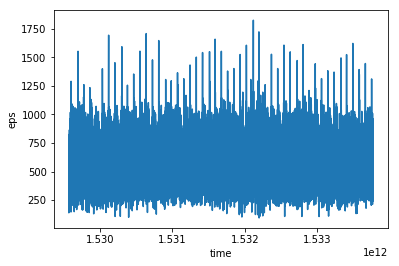

In [5]:
sns.lineplot(x='time', y='eps', data=df)
#sns.lineplot(x='time', y='eps', data=df[:200])

In [6]:
def convertEpochToDate():
    df['date'] = pd.to_datetime(df['time'], unit='ms')

#convertEpochToDate()

In [7]:
def determineWeekDay():
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M")
    df['weekday'] = df['date'].dt.weekday
    
#determineWeekDay()
#sns.boxplot(x="weekday", y="eps", data=df)

In [7]:
#df = df.set_index('date')

In [8]:
def test_stationarity(timeseries, window = 60):
    rollMean = timeseries.rolling(window).mean()
    rollStd = timeseries.rolling(window).std()

    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, label = 'Original')
    mean = plt.plot(rollMean, label = 'Rolling Mean')
    std  = plt.plot(rollStd, label = 'Rolling Std')

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')

    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    
    print(dfoutput)


In [9]:
#Window is for 24 hrs: 60*24
window_size = 1440

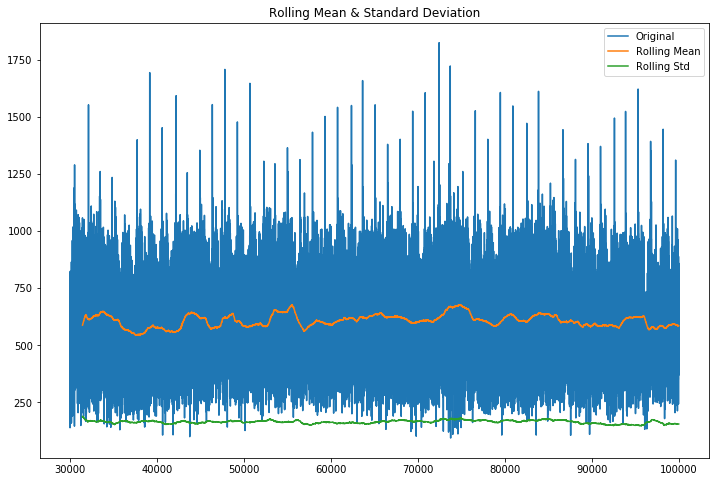

Results of Dickey-Fuller Test:
Test Statistic                -1.282346e+01
p-value                        6.083720e-24
#Lags Used                     6.100000e+01
Number of Observations Used    6.993800e+04
Critical Value (1%)           -3.430444e+00
Critical Value (5%)           -2.861581e+00
Critical Value (10%)          -2.566792e+00
dtype: float64


In [10]:
test_stationarity(df['eps'], window = window_size)

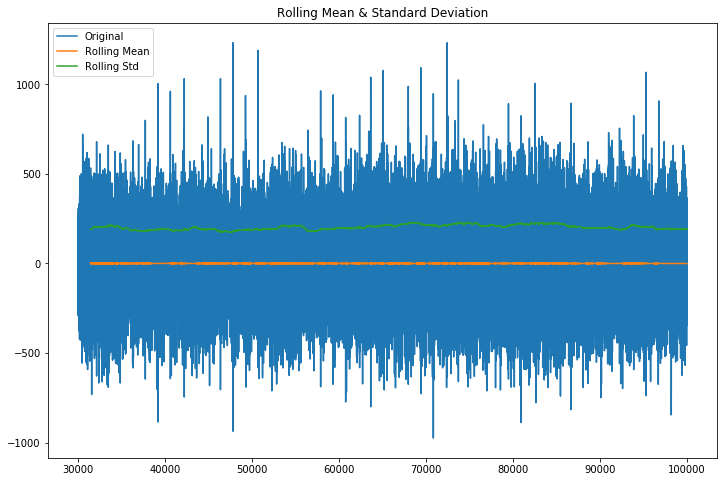

Results of Dickey-Fuller Test:
Test Statistic                   -54.909801
p-value                            0.000000
#Lags Used                        62.000000
Number of Observations Used    69936.000000
Critical Value (1%)               -3.430444
Critical Value (5%)               -2.861581
Critical Value (10%)              -2.566792
dtype: float64


In [12]:
df_diff = df['eps'] - df['eps'].shift(1)
df_diff = df_diff.dropna(inplace = False)
test_stationarity(df_diff, window = window_size)

In [14]:
def seasonalDecompose(timeSeries):
    seasonal_decompose_result = seasonal_decompose(timeSeries, freq = window_size)

    fig = plt.figure()
    fig = seasonal_decompose_result.plot()
    fig.set_size_inches(15, 12)

    return seasonal_decompose_result

<Figure size 432x288 with 0 Axes>

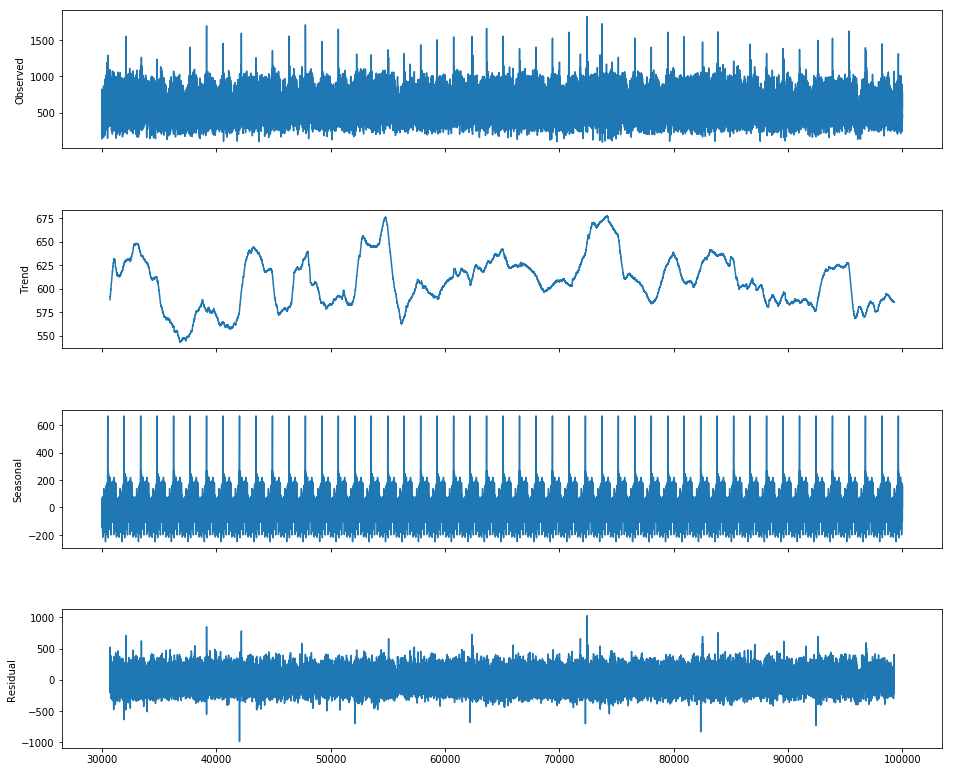

<Figure size 432x288 with 0 Axes>

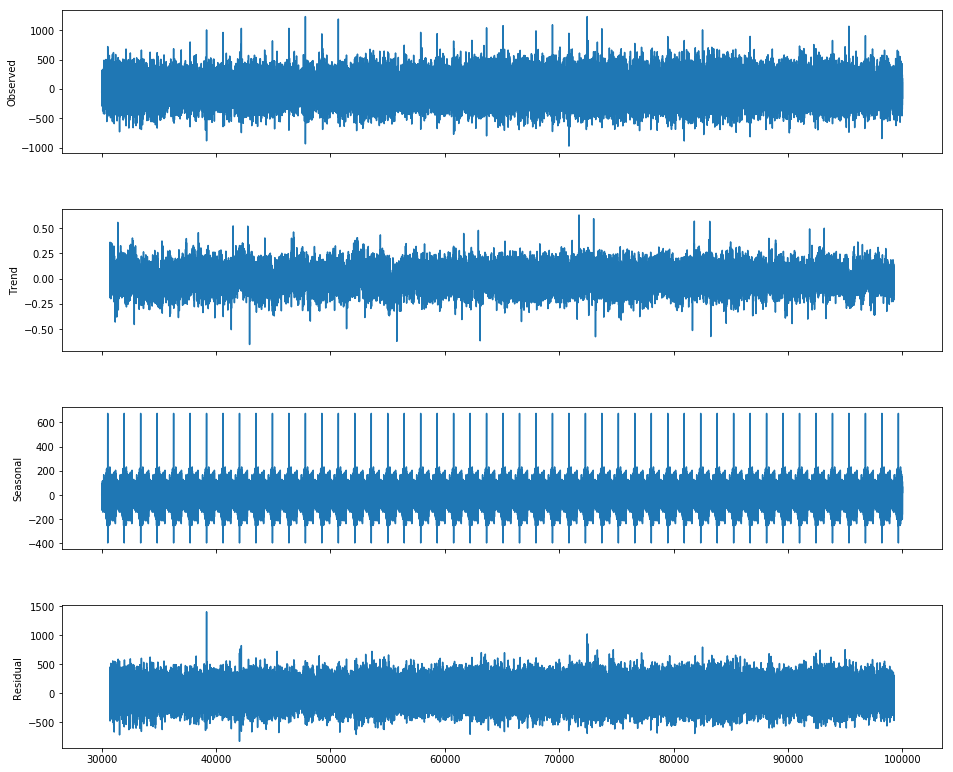

In [15]:
decompose_result = seasonalDecompose(df['eps'])
decompose_result_diff = seasonalDecompose(df_diff)

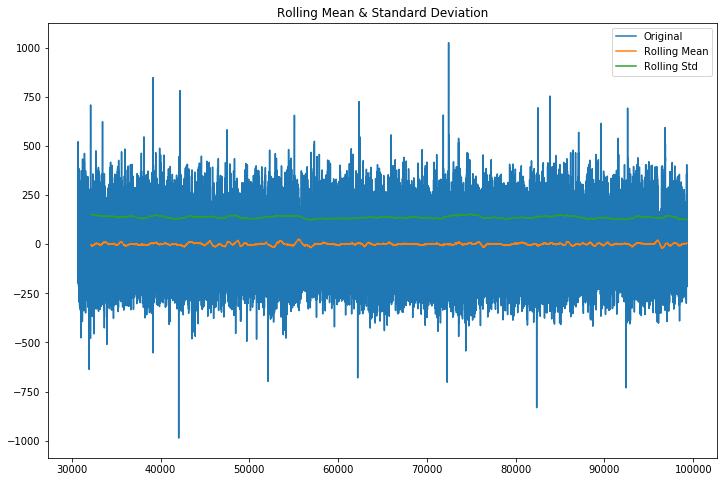

Results of Dickey-Fuller Test:
Test Statistic                   -18.930825
p-value                            0.000000
#Lags Used                        62.000000
Number of Observations Used    68497.000000
Critical Value (1%)               -3.430445
Critical Value (5%)               -2.861582
Critical Value (10%)              -2.566792
dtype: float64


In [18]:
#ADF of residual
decompose_residual = decompose_result.resid
decompose_residual.dropna(inplace=True)
test_stationarity(decompose_residual, window = window_size)

In [19]:
def plotAcfAndPacf(series, lag = 40):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, lags = lag, ax = ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags = lag, ax = ax2)

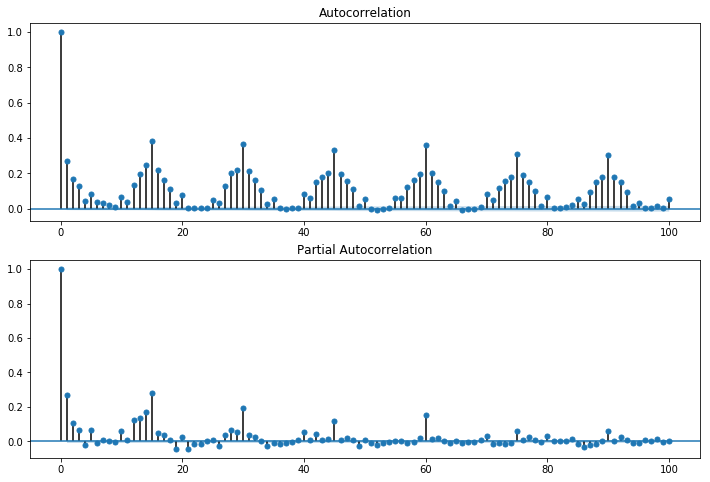

In [25]:
#plotAcfAndPacf(df_diff, lag = 20)
plotAcfAndPacf(df['eps'], lag = 100)

In [21]:
p = [4]
d = [1]
q = [4]
s = [1440]

pdq = list(itertools.product(p, d, q))
PDQs = list(itertools.product(p, d, q, s))

In [22]:
def calculateAllPossibilities():
    for param in pdq:
        for seasonal_param in PDQs:
            print('SARIMA for {}x{}'.format(param, seasonal_param))
            sarima_results = sm.tsa.statespace.SARIMAX(
                df['eps'],
                order = param,
                seasonal_order = seasonal_param,
                enforce_stationarity = False,
                enforce_invertibility = False).fit()

            print('Beginning to fit')
            #sarima_results = sarima_mod
            print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_param, sarima_results.aic))


#calculateAllPossibilities()

In [26]:
def plotResidualDistribution(sarima_result):
    residual = sarima_result.resid
    print(normaltest(residual))

    fig = plt.figure(figsize=(10,8))
    ax0 = fig.add_subplot(111)

    sns.distplot(residual ,fit = stats.norm, ax = ax0)

In [ ]:
sarima_mod_result = sm.tsa.statespace.SARIMAX(df['eps'][:10000], 
                                              order=(2,1,2), 
                                              seasonal_order=(2, 1, 2, 60),
                                              trend='n',
                                              enforce_stationarity = False,
                                              enforce_invertibility = False).fit()

NormaltestResult(statistic=230.4855660138075, pvalue=8.926788821773606e-51)
                                 Statespace Model Results                                 
Dep. Variable:                                eps   No. Observations:                10000
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 15)   Log Likelihood              -63297.008
Date:                            Thu, 30 Aug 2018   AIC                         126612.015
Time:                                    20:52:32   BIC                         126676.864
Sample:                                         0   HQIC                        126633.971
                                          - 10000                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5099      0.734     -

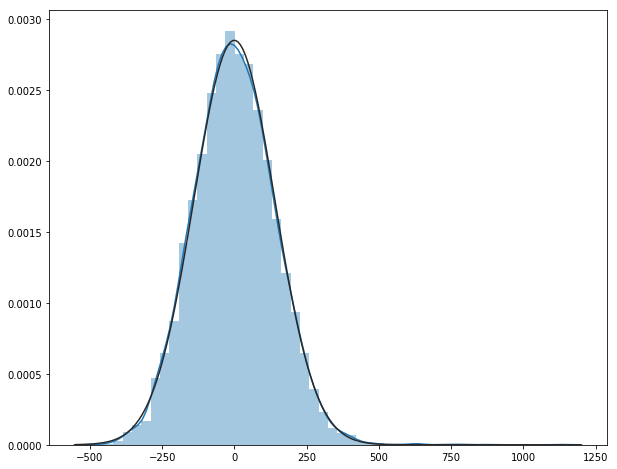

In [65]:
plotResidualDistribution(sarima_mod_result)
print(sarima_mod_result.summary())

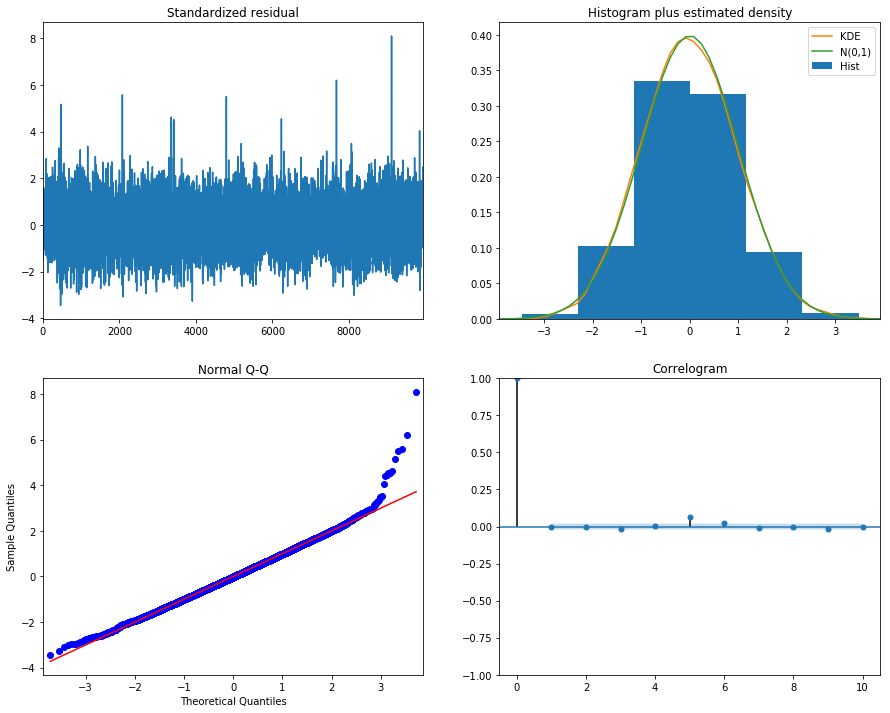

In [66]:
sarima_mod_result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [67]:
pred = sarima_mod_result.get_prediction(start = 500, end = 505, dynamic=False)
pred_ci = pred.conf_int()
pred.predicted_mean.head(15)

30500    711.815517
30501    679.485583
30502    836.403151
30503    741.263977
30504    815.977474
30505    871.656612
dtype: float64

In [68]:
df['eps'][500:505]

30500    566
30501    928
30502    576
30503    702
30504    902
Name: eps, dtype: int64

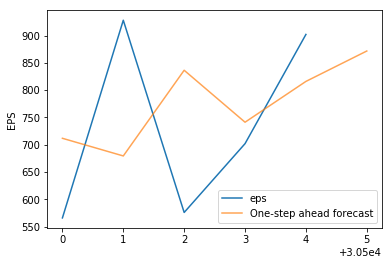

In [69]:
ax = df['eps'][500:505].plot(label='eps')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

#ax.set_xlabel('Time (years)')
ax.set_ylabel('EPS')
plt.legend()

plt.show()

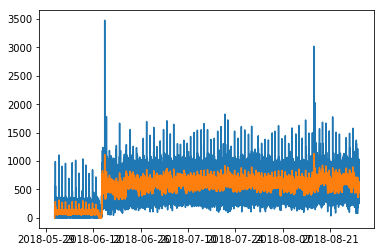

In [62]:
plt.plot(df['eps'])
plt.plot(sarima_mod1.fittedvalues)

D:\Tools\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Tools\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Tools\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


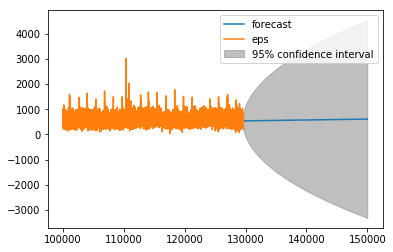

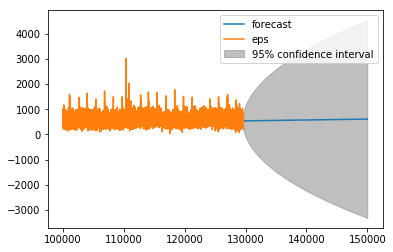

In [67]:
arima_mod1.plot_predict(100000,150000)